### CP#34 - IncomeInsight: Predicting Earning Potential from Demographic & Employment Data

Exporatory Data Analysis  
URL: https://www.kaggle.com/datasets/uciml/adult-census-income

Findings:
- There are no empty cells, and only integer and object types
- ? marks are in workclass, occupation and native.country columns
- ? marks appear randomly distributed and make up ~7% of records - dropped from analysis
- Sex and Income (<=50K, >50K) are binary objects
- Capital gain and loss are heavily skewed and can be represented as binary
- education.num has the strongest correlation with earning >$50K, a second tier is led by whether there are capital gains or not, followed closely by age and hours.per.week
- Higher education levels (education.num) and more hours per week generally correspond to higher income.
- Married individuals are more likely to earn >$50K than singles, and correlates most as a binary (married & together or not)
- Relationship has a stronger statistical association with income than marital.status, and correlates most as binary (Husband/Wife or not)
- Binary marital.status and relationship almost perfectly correlate and both are not needed.
- Males are more likely than females to earn >$50K
- Asian-Pacific-Islanders had the highest percentage of high earners, and White individuals were a close second but with far more representation
- Native country also plays a role, with people from Taiwan most evenly split and the US ranked 17th with percentage of high earners, but substantially more represented
- Individuals with non-zero capital.gain values are significantly more likely to earn >$50K
- More than 50% chance of earning >$50K if you are self-employed and incorporated, but least statistically impactful category
- The target variable Income is not balanced, with 75% <=$50K
- fnlwgt column is not impactful

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

sns.set(style="whitegrid")

In [2]:
# Download the dataset
kaggle.api.dataset_download_files('uciml/adult-census-income', path='../data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income


In [3]:
data = pd.read_csv("../data/adult.csv")
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Task 1:  Handle missing values and inconsistent formatting (e.g., “?” entries)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [92]:
unique_counts = data.nunique()
print(unique_counts)

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64


In [93]:
data.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# Get lists of column names by type
bin_cols = ['sex', 'income']
int_cols = data.select_dtypes(include='int').columns.tolist()
obj_cols = data.select_dtypes(include='object').columns.tolist()

# Remove binary columns from object columns
obj_cols = list(set(obj_cols) - set(bin_cols))

print("Binary columns:", bin_cols)
print("Integer columns:", int_cols)
print("Object columns:", obj_cols)

Binary columns: ['sex', 'income']
Integer columns: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Object columns: ['relationship', 'workclass', 'marital.status', 'race', 'native.country', 'education', 'occupation']


In [95]:
# List unique values in text columns
for col in bin_cols:
    print(f"Unique values in '{col}':")
    print(sorted(data[col].unique()))
    print()

for col in obj_cols:
    print(f"Unique values in '{col}':")
    print(sorted(data[col].unique()))
    print()

Unique values in 'sex':
['Female', 'Male']

Unique values in 'income':
['<=50K', '>50K']

Unique values in 'race':
['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']

Unique values in 'relationship':
['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']

Unique values in 'occupation':
['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']

Unique values in 'education':
['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']

Unique values in 'workclass':
['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

Unique values in 'marital.status':
['Divor

In [96]:
# How many missing values are there using the question mark?
missing_counts = {}
for col_name in ['workclass', 'occupation', 'native.country']:
    missing_counts[col_name] = (data[col_name] == '?').sum()
print(missing_counts)

{'workclass': np.int64(1836), 'occupation': np.int64(1843), 'native.country': np.int64(583)}


In [97]:
# Percentage of rows with any "?" in object columns
rows_with_question = data[obj_cols].apply(lambda row: row.str.contains(r'\?')).any(axis=1).sum()
percentage = (rows_with_question / len(data)) * 100
print(f"Percentage of rows containing '?': {percentage:.2f}%")

Percentage of rows containing '?': 7.37%


In [7]:
# Are the "?" entries randomly distributed?

# Add a column indicating if any object column has a "?" entry
data['has_question'] = data[obj_cols].apply(lambda row: row.str.contains(r'\?')).any(axis=1)

# Compare mean age (or other features) for rows with and without "?"
print("Age statistics by 'has_question':")
print(data.groupby('has_question')['age'].describe())
print()

# Gender statistics: number of 'Male' records with has_question True and total 'Male' records
num_male_with_question = ((data['sex'] == 'Male') & (data['has_question'])).sum()
num_male_total = (data['sex'] == 'Male').sum()
print(f"Number of 'Male' records with has_question=True: {num_male_with_question}")
print(f"Total number of 'Male' records: {num_male_total}")
if num_male_total > 0:
    print(f"Proportion: {num_male_with_question / num_male_total:.2%}")
print()

# Gender statistics: number of 'Female' records with has_question True and total 'Female' records
num_female_with_question = ((data['sex'] == 'Female') & (data['has_question'])).sum()
num_female_total = (data['sex'] == 'Female').sum()
print(f"Number of 'Female' records with has_question=True: {num_female_with_question}")
print(f"Total number of 'Female' records: {num_female_total}")
if num_female_total > 0:
    print(f"Proportion: {num_female_with_question / num_female_total:.2%}")
print()

# Compare income distribution
print(data.groupby('has_question')['income'].value_counts(normalize=True))


Age statistics by 'has_question':
                count       mean        std   min   25%   50%   75%   max
has_question                                                             
False         30162.0  38.437902  13.134665  17.0  28.0  37.0  47.0  90.0
True           2399.0  40.388912  18.786609  17.0  22.0  36.0  58.0  90.0

Number of 'Male' records with has_question=True: 1410
Total number of 'Male' records: 21790
Proportion: 6.47%

Number of 'Female' records with has_question=True: 989
Total number of 'Female' records: 10771
Proportion: 9.18%

has_question  income
False         <=50K     0.751078
              >50K      0.248922
True          <=50K     0.861192
              >50K      0.138808
Name: proportion, dtype: float64


*With roughly similar distribution of question marks, they appear to be random.  And at less than 10% of our data, it appears acceptable to delete these incomplete records.*

In [8]:
# Delete rows with "?" in object columns
data_cleaned = data[~data['has_question']].drop(columns=['has_question'])

In [100]:
# Binary encoding for income, sex, marital.status, relationship, capital gain & loss columns
data_cleaned['income_bin'] = data_cleaned['income'].apply(lambda x: 1 if x == '>50K' else 0)
data_cleaned['sex_bin'] = data_cleaned['sex'].apply(lambda x: 1 if x == 'Male' else 0)
data_cleaned['marital_bin'] = data_cleaned['marital.status'].apply(lambda x: 1 if x == 'Married-AF-spouse' or x == 'Married-civ-spouse' else 0)
data_cleaned['relation_bin'] = data_cleaned['relationship'].apply(lambda x: 1 if x == 'Husband' or x == 'Wife' else 0)
data_cleaned['gain_bin'] = data_cleaned['capital.gain'].apply(lambda x: 1 if x > 0 else 0)
data_cleaned['loss_bin'] = data_cleaned['capital.loss'].apply(lambda x: 1 if x > 0 else 0)

## Correlation heatmap

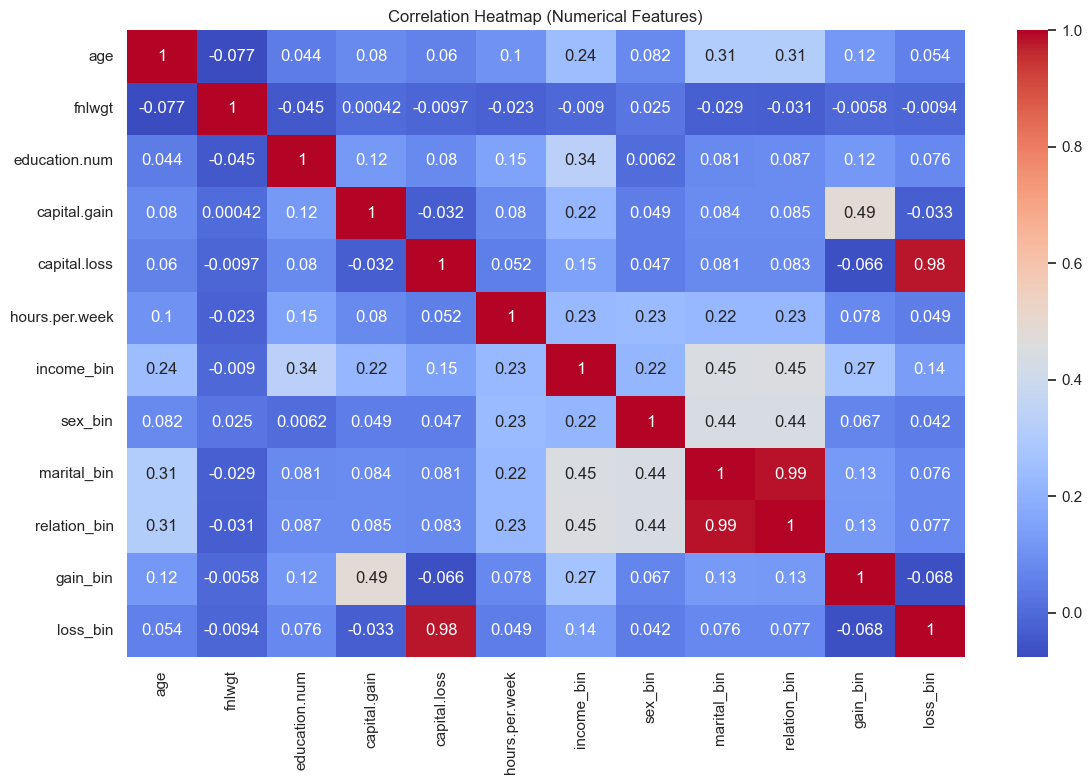

In [101]:
# Correlation of numerical features
num_cols = data_cleaned.select_dtypes(include='number')
corr = num_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()

In [102]:
# Numerical features averages with income
grouped_means = data_cleaned.groupby('income')[int_cols].mean()
grouped_means = grouped_means.T.sort_values(by='>50K', ascending=True)
print(round(grouped_means,2))

income              <=50K       >50K
education.num        9.63      11.61
age                 36.61      43.96
hours.per.week      39.35      45.71
capital.loss        53.45     193.75
capital.gain       148.89    3937.68
fnlwgt          190338.65  188149.96


*fnlwgt column does not appear impactful*

##Distribution plots

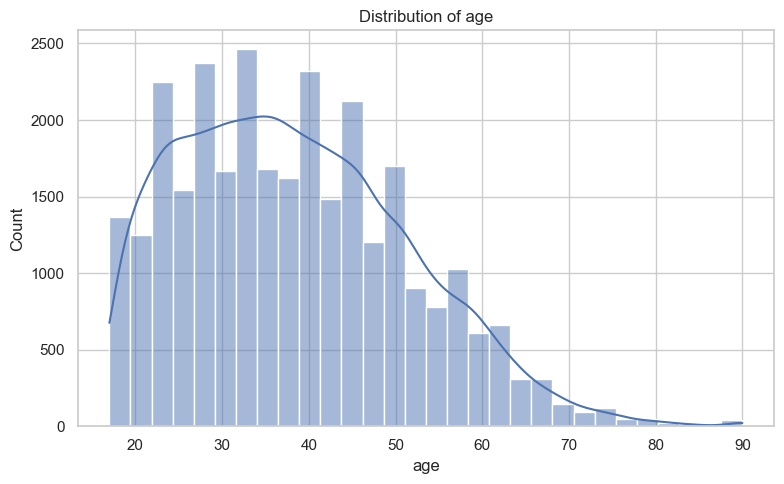

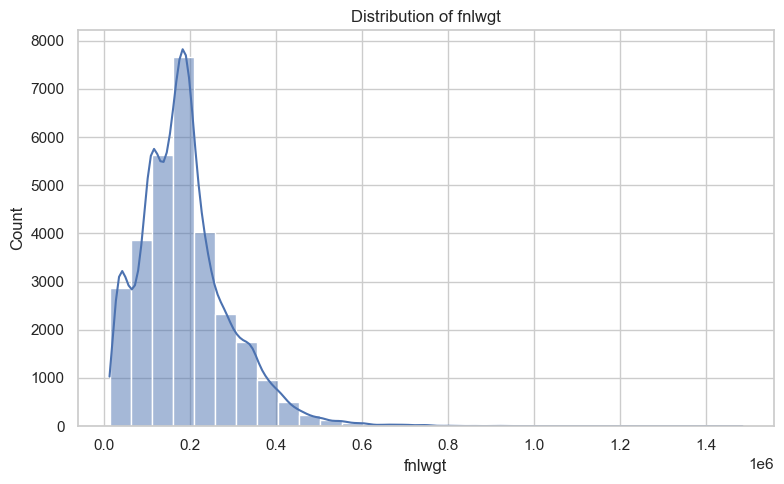

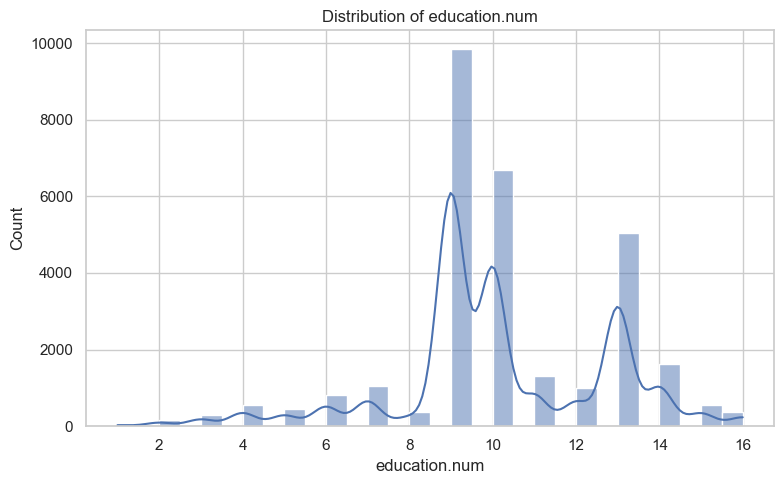

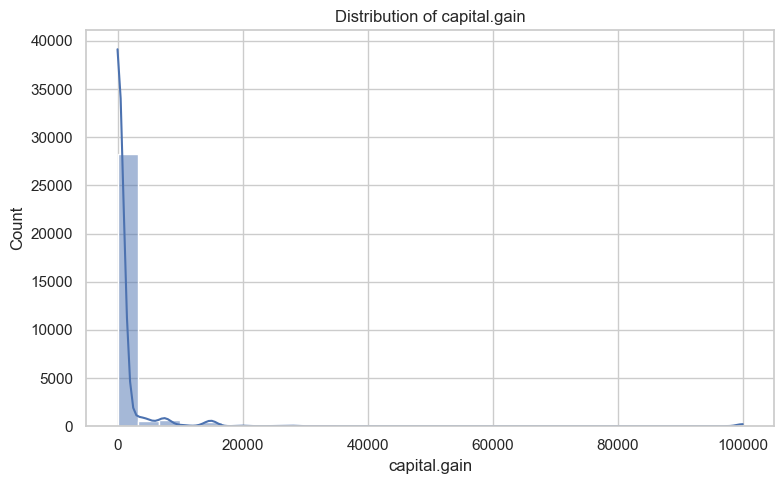

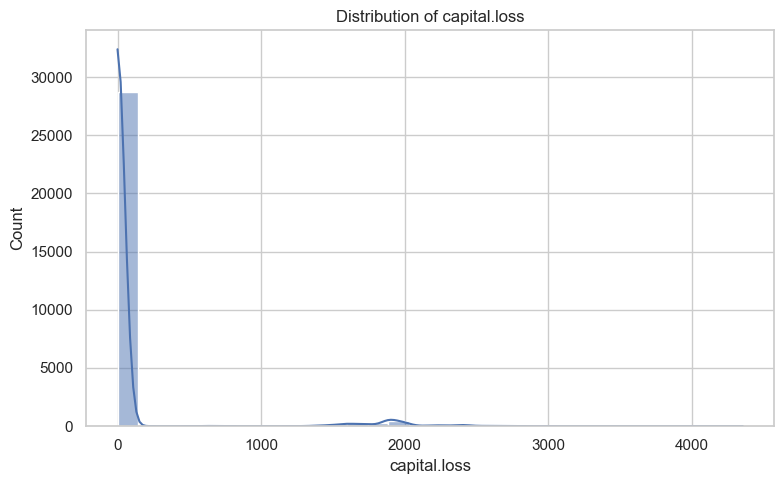

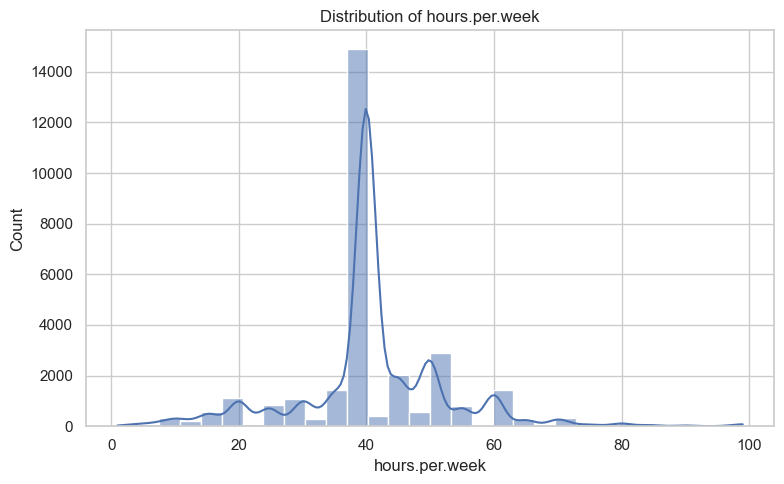

In [103]:
# Distribution plots for key numeric features
for col in int_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_cleaned[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

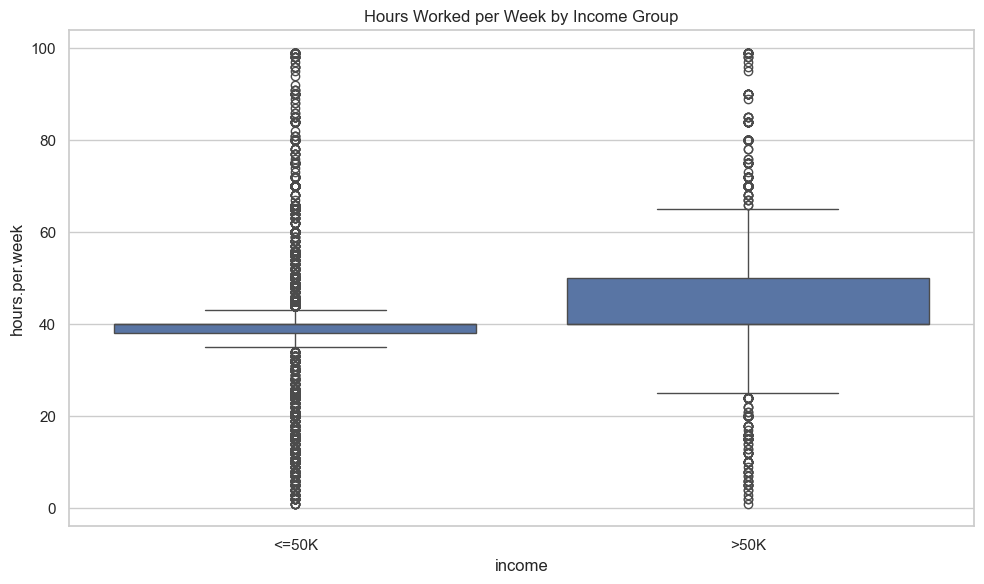

In [104]:
# Hours worked per week by income group
plt.figure(figsize=(10, 6))
sns.boxplot(x='income', y='hours.per.week', data=data_cleaned)
plt.title('Hours Worked per Week by Income Group')
plt.tight_layout()
plt.show()

Income proportions by category

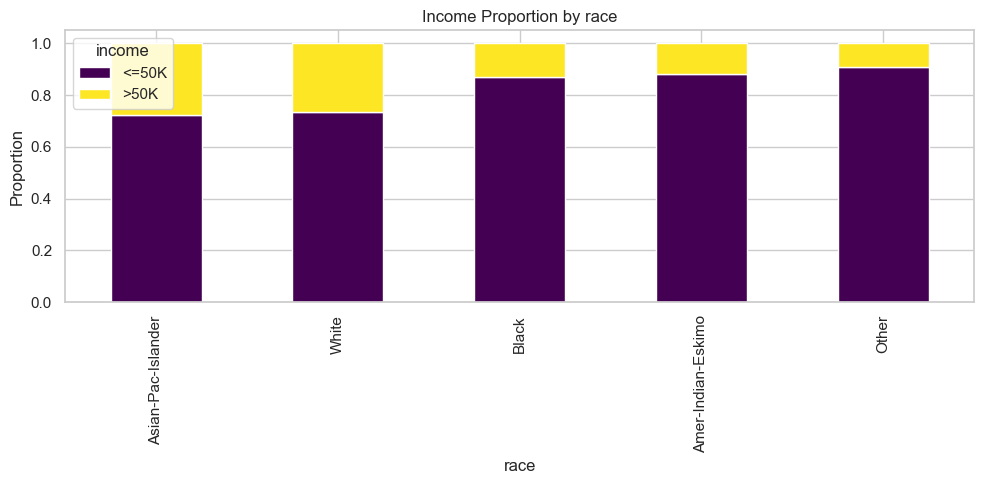

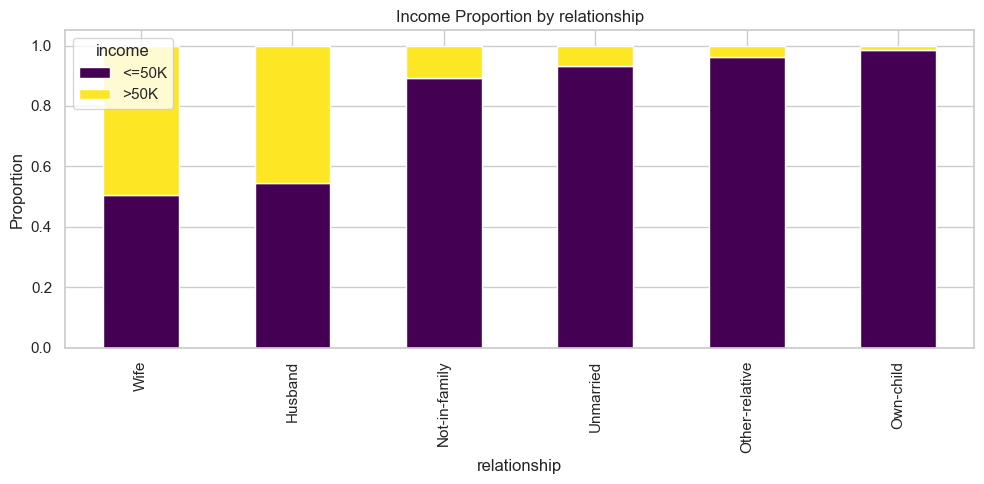

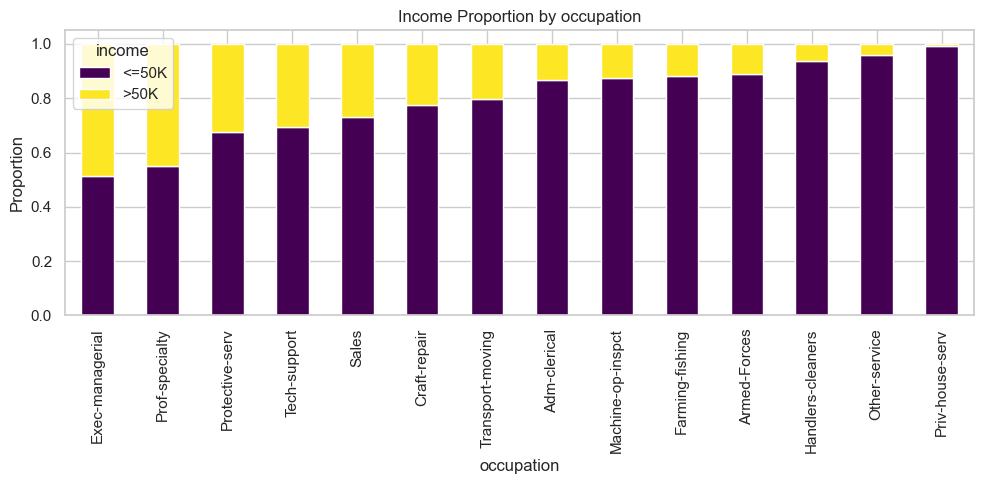

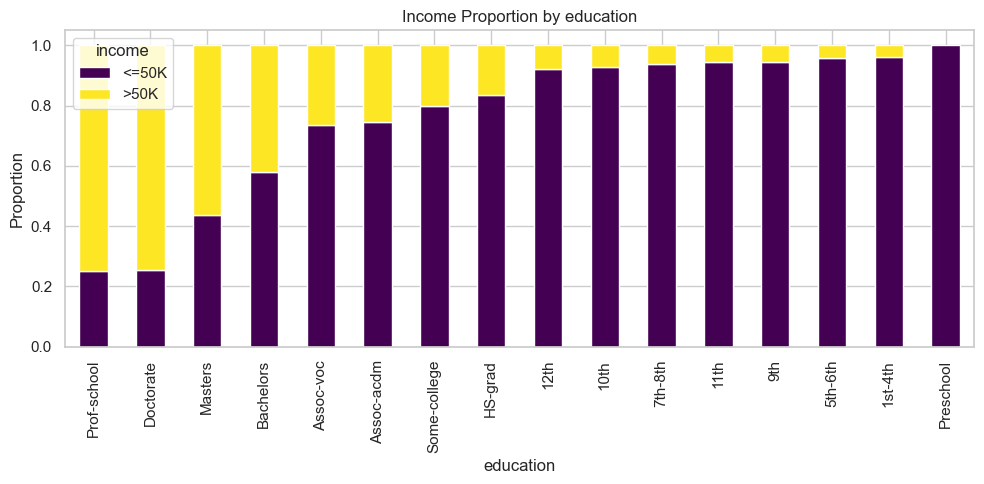

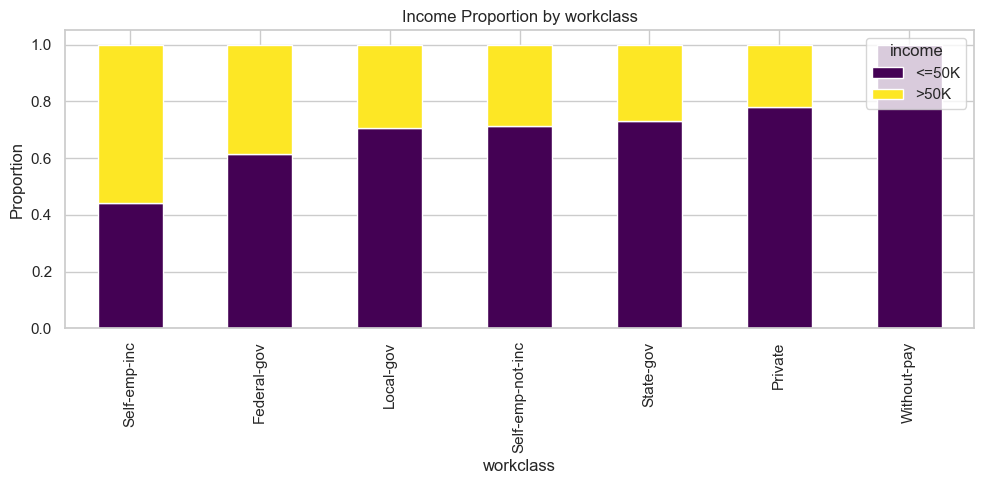

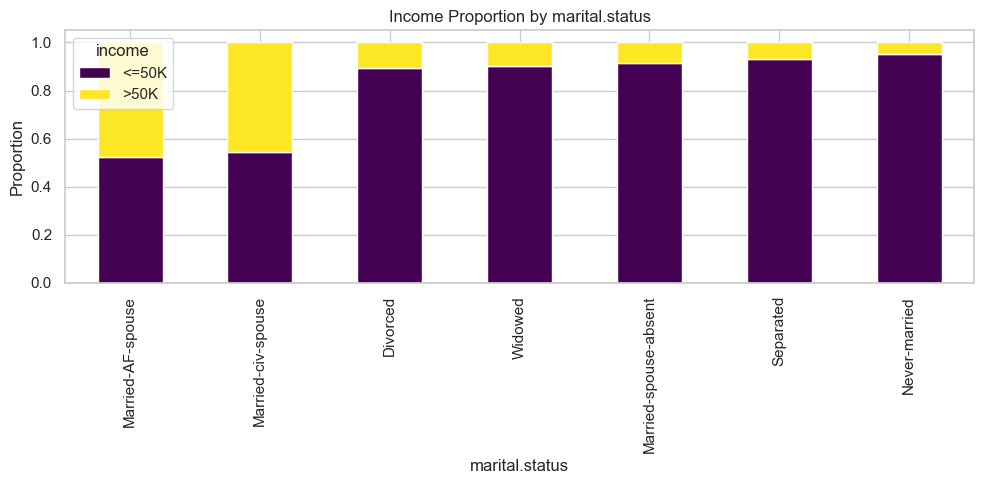

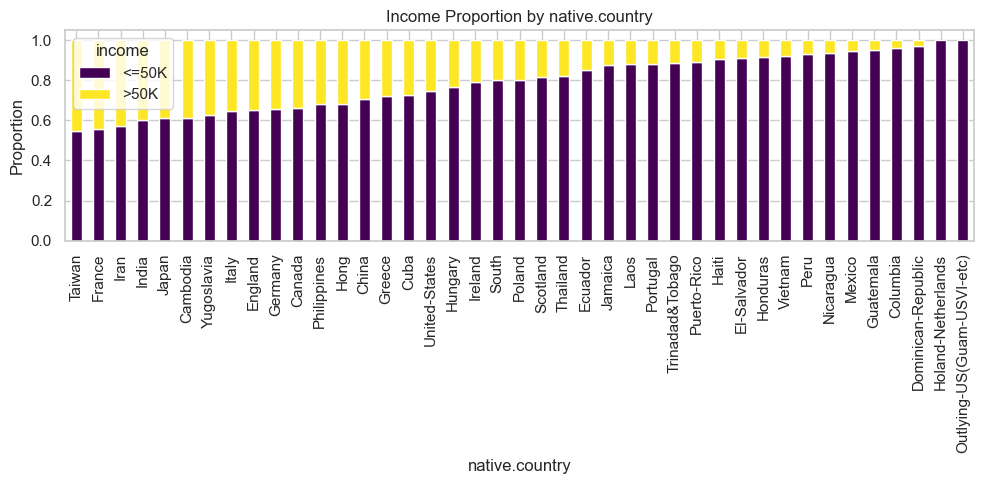

In [105]:
# Loop through each object column and create stacked bar chart of income proportions
for col in obj_cols:
    if col == 'income':
        continue  # skip target

    # Create normalized crosstab
    income_dist = pd.crosstab(data_cleaned[col], data_cleaned['income'], normalize='index')

    # Sort by >50K proportion if available
    if '>50K' in income_dist.columns:
        income_dist = income_dist.sort_values(by='>50K', ascending=False)

    # Plot
    income_dist.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='viridis')
    plt.title(f'Income Proportion by {col}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [109]:
# country by representation
data_cleaned.groupby('native.country')['native.country'].count().sort_values(ascending=False).head(10)

native.country
United-States    27504
Mexico             610
Philippines        188
Germany            128
Puerto-Rico        109
Canada             107
El-Salvador        100
India              100
Cuba                92
England             86
Name: native.country, dtype: int64

In [12]:
# country by proportion of >50K income
country_income_proportion = data_cleaned.groupby('native.country')['income'].value_counts(normalize=True).unstack().fillna(0)
country_income_proportion = country_income_proportion.sort_values(by='>50K', ascending=False)
print(round(country_income_proportion,2))

income                      <=50K  >50K
native.country                         
Taiwan                       0.55  0.45
France                       0.56  0.44
Iran                         0.57  0.43
India                        0.60  0.40
Japan                        0.61  0.39
Cambodia                     0.61  0.39
Yugoslavia                   0.62  0.38
Italy                        0.65  0.35
England                      0.65  0.35
Germany                      0.66  0.34
Canada                       0.66  0.34
Philippines                  0.68  0.32
Hong                         0.68  0.32
China                        0.71  0.29
Greece                       0.72  0.28
Cuba                         0.73  0.27
United-States                0.75  0.25
Hungary                      0.77  0.23
Ireland                      0.79  0.21
South                        0.80  0.20
Poland                       0.80  0.20
Scotland                     0.82  0.18
Thailand                     0.82  0.18


*the top 30 countries have >=10% of population earning >50K, call the remainder 'Other' to reduce encoding, or test boundary*

In [106]:
# education by education.num
unique_education = data_cleaned[['education.num', 'education']].drop_duplicates().sort_values(by='education.num')
print(unique_education)

      education.num     education
1106              1     Preschool
26                2       1st-4th
27                3       5th-6th
3                 4       7th-8th
197               5           9th
6                 6          10th
16                7          11th
178               8          12th
1                 9       HS-grad
4                10  Some-college
25               11     Assoc-voc
60               12    Assoc-acdm
12               13     Bachelors
13               14       Masters
11               15   Prof-school
7                16     Doctorate


In [107]:
# marital.status by relationship
unique_marital = data_cleaned[['marital.status', 'relationship']].drop_duplicates().sort_values(by='marital.status')
print(unique_marital)

              marital.status    relationship
1083                Divorced  Other-relative
3                   Divorced       Unmarried
909                 Divorced       Own-child
8                   Divorced   Not-in-family
14214      Married-AF-spouse       Own-child
15557      Married-AF-spouse  Other-relative
2871       Married-AF-spouse         Husband
4263       Married-AF-spouse            Wife
23        Married-civ-spouse         Husband
26        Married-civ-spouse   Not-in-family
62        Married-civ-spouse            Wife
189       Married-civ-spouse  Other-relative
241       Married-civ-spouse       Own-child
1357   Married-spouse-absent  Other-relative
45     Married-spouse-absent       Unmarried
328    Married-spouse-absent   Not-in-family
1004   Married-spouse-absent       Own-child
11             Never-married   Not-in-family
149            Never-married       Own-child
302            Never-married       Unmarried
7              Never-married  Other-relative
151       

In [108]:
# race by representation
data_cleaned.groupby('race')['race'].count().sort_values(ascending=False)

race
White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: race, dtype: int64

In [110]:
# Is target variable balanced?
income_counts = data_cleaned['income'].value_counts(normalize=True)
print("Income distribution:")
print(round(income_counts,2))

Income distribution:
income
<=50K    0.75
>50K     0.25
Name: proportion, dtype: float64


*will have to address target variable imbalance*

## Chi-squared test

In [111]:
# Encode categorical features
X_cat = data_cleaned[obj_cols].apply(LabelEncoder().fit_transform)
y = data_cleaned['income_bin']

# Run chi-squared test
chi_scores, p_vals = chi2(X_cat, y)

# Display results
pd.DataFrame({'Feature': obj_cols, 'Chi2 Score': chi_scores, 'p-value': p_vals}).sort_values(by='Chi2 Score', ascending=False).round(2)

,Feature,Chi2 Score,p-value
1,relationship,3435.49,0.00
5,marital.status,982.38,0.00
3,education,264.65,0.00
2,occupation,218.59,0.00
0,race,29.33,0.00
6,native.country,16.73,0.00
4,workclass,4.06,0.04


*relationship category has a stronger statistical association with income than marital.status, but their binary versions correlate to each other almost perfectly.  Marital status has a simpler interpretation and may not need relationship in regressions due to multicollinearity or tree based models due to redundancy*

Output

In [112]:
# Drop unnecessary and exploratory columns
data_cleaned = data_cleaned.drop(columns=[col for col in data_cleaned.columns if col.endswith('_bin')])
data_cleaned = data_cleaned.drop(columns=['fnlwgt', 'capital.loss', 'relationship'])

data_cleaned.reset_index(drop=True, inplace=True)

data_cleaned.to_csv("../data/adult_cleaned.csv")